<a href="https://colab.research.google.com/github/ArjunKanthimath/Synthetic-Image-Generation-Preprocessing-and-Flux-Model-Forward-Pass/blob/main/Image_Synthesis_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
import os
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

Using device: cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated image 1


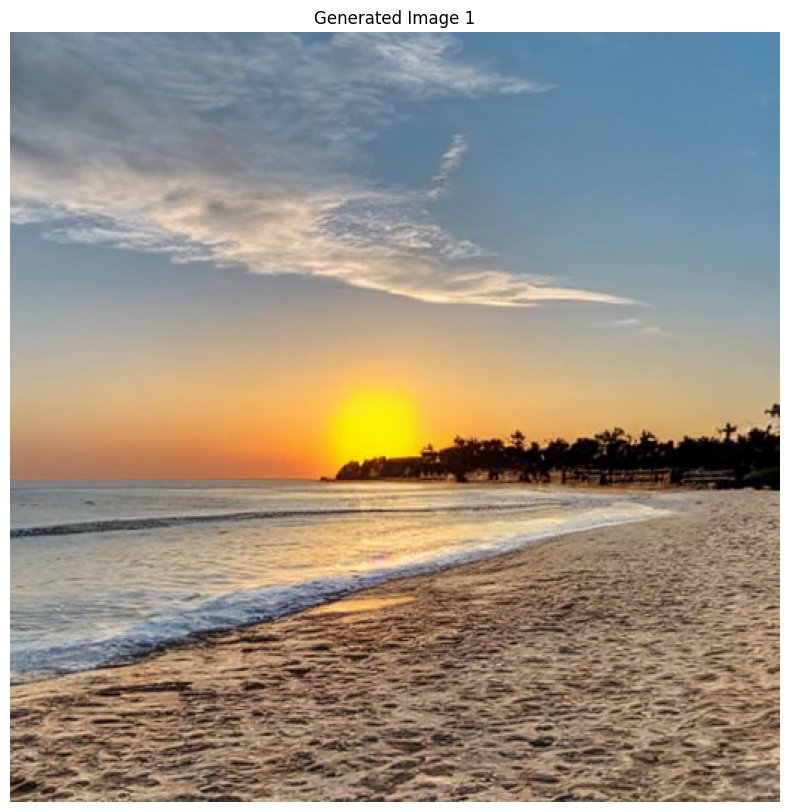

  0%|          | 0/50 [00:00<?, ?it/s]

Generated image 2


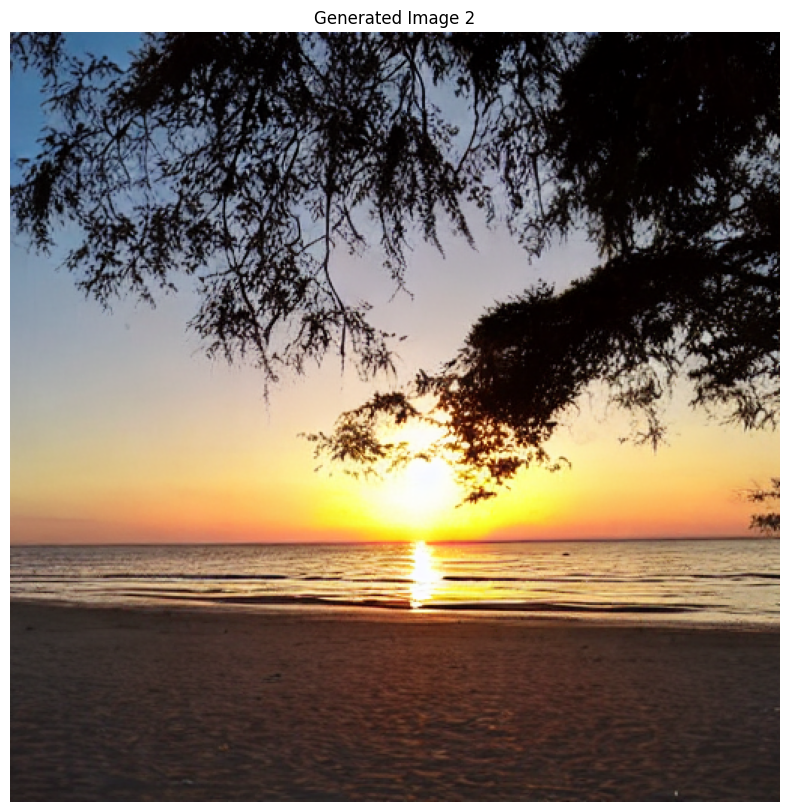

  0%|          | 0/50 [00:00<?, ?it/s]

Generated image 3


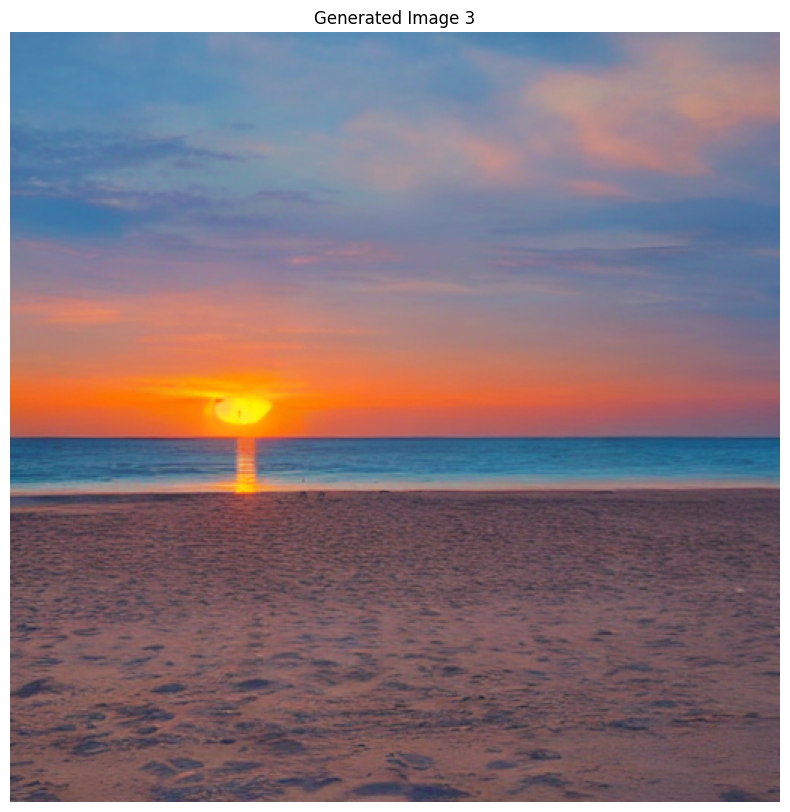

In [ ]:
# Create folders
!mkdir -p generated_images preprocessed_images

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)
pipe = pipe.to(device)

# Generate images
prompt = "a serene sunset by a beach side"
num_images = 3
image_paths = []

for i in range(num_images):
    image = pipe(prompt).images[0]
    image_path = f"generated_images/sunset_{i+1}.png"
    image.save(image_path)
    image_paths.append(image_path)
    print(f"Generated image {i+1}")

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Generated Image {i+1}")
    plt.show()

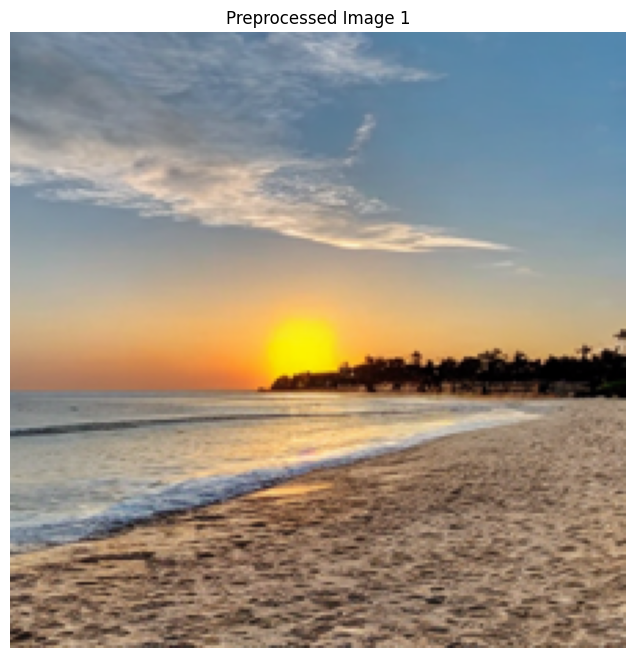

Preprocessed image 1, shape: (3, 224, 224)


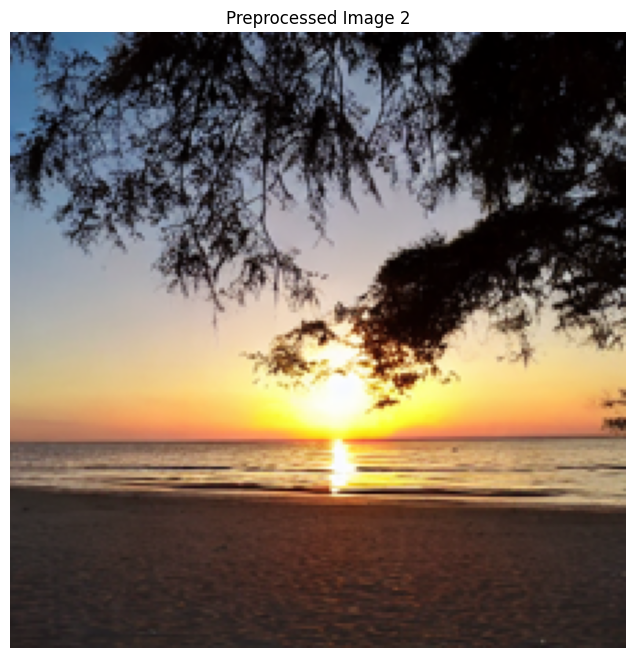

Preprocessed image 2, shape: (3, 224, 224)


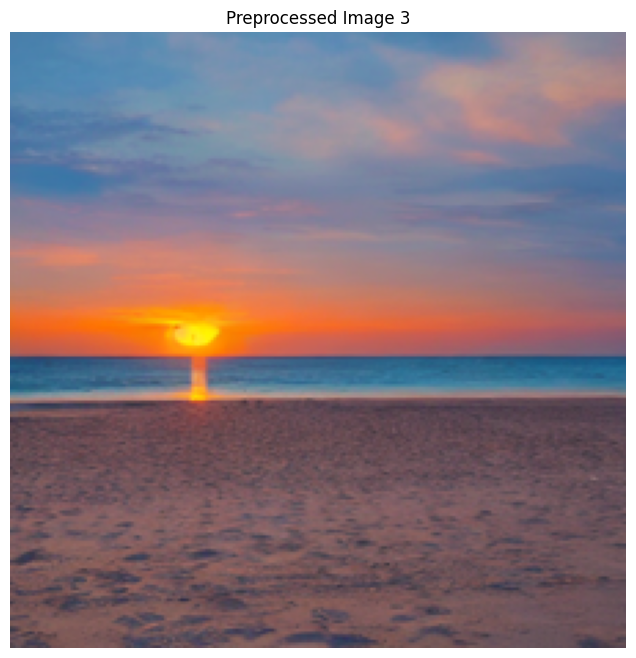

Preprocessed image 3, shape: (3, 224, 224)


In [ ]:
preprocessed_paths = []

for i, img_path in enumerate(image_paths):
    # Load image
    image = Image.open(img_path)

    # Resize
    target_size = (224, 224)
    resized_image = image.resize(target_size)

    # Convert to numpy array and normalize (0-1)
    image_array = np.array(resized_image).astype(np.float32) / 255.0

    # Save preprocessed image for visualization
    output_path = f"preprocessed_images/preprocessed_{i+1}.png"
    plt.imsave(output_path, image_array)

    # Reshape to match Flux's expected input format (channels-first)
    if len(image_array.shape) == 3:
        image_array = np.transpose(image_array, (2, 0, 1))

    # Save as numpy array
    np_output_path = f"preprocessed_images/preprocessed_{i+1}.npy"
    np.save(np_output_path, image_array)
    preprocessed_paths.append(np_output_path)

    # Display the preprocessed image
    plt.figure(figsize=(8, 8))
    plt.imshow(np.array(resized_image))
    plt.axis('off')
    plt.title(f"Preprocessed Image {i+1}")
    plt.show()

    print(f"Preprocessed image {i+1}, shape: {image_array.shape}")

In [47]:
# Installing IJulia
!julia -e 'using Pkg; Pkg.add("IJulia"); Pkg.add("Conda")'

# Set up of Julia kernel
!julia -e 'using IJulia; installkernel("Julia")'

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [8f4d0f93] + Conda v1.10.2
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
[ Info: Installing Julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10


In [1]:
!pip install julia
import julia
julia.install()
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.9 MB/s eta 0:00:00



Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.


In [2]:
# Defining a function to execute Julia code
def julia_exec(code):
    return Main.eval(jl.eval(code))

# Installing necessary Julia packages
julia_exec("""
using Pkg
Pkg.add(["Flux", "Images", "FileIO", "NPZ", "Statistics"])
""")

# Loading the necessary packages
julia_exec("""
using Flux
using Images
using FileIO
using NPZ
using Statistics
""")

In [3]:
%%writefile flux_model.jl
using Pkg
Pkg.add(["Flux", "Images", "FileIO", "NPZ", "Statistics", "BSON"])

using Flux
using Images
using FileIO
using NPZ
using Statistics
using BSON: @save

img_path = ARGS[1]

# Loading and preprocessing the image
println("Loading and preprocessing image from: ", img_path)
img_tensor = npzread(img_path)

println("Original tensor shape: ", size(img_tensor))

# Flux format (height, width, channels, batch)
if length(size(img_tensor)) == 3
    # If tensor is (channels, height, width), permute to (height, width, channels)
    if size(img_tensor)[1] in [1, 3, 4] && size(img_tensor)[2] > 4 && size(img_tensor)[3] > 4
        img_tensor = permutedims(img_tensor, (2, 3, 1))
        println("Permuted tensor shape (height, width, channels): ", size(img_tensor))
    end

    # Batch dimension
    img_tensor = reshape(img_tensor, (size(img_tensor)..., 1))
    println("Final tensor shape with batch (height, width, channels, batch): ", size(img_tensor))
end

# Convert to Float32
img_tensor = Float32.(img_tensor)

# Get dimensions for model creation
height, width, channels, batch = size(img_tensor)

# Calculate dimensions after max pooling twice
height_after_pool = height ÷ 4
width_after_pool = width ÷ 4

# Defining a simple CNN model
model = Chain(
    # First convolutional layer
    Conv((3, 3), channels => 16, relu; pad=1),
    MaxPool((2, 2)),

    # Second convolutional layer
    Conv((3, 3), 16 => 32, relu; pad=1),
    MaxPool((2, 2)),

    # Flatten the output for the dense layer
    Flux.flatten,

    # Dense layers
    Dense(32 * height_after_pool * width_after_pool, 64, relu),
    Dense(64, 10),
    softmax
)

println("Model architecture:")
println(model)

# Performing forward pass
output = model(img_tensor)

println("Forward pass complete!")
println("Output shape: ", size(output))
println("Output values (first few):")
println(output[:, 1][1:5])

# Saving the model
@save "flux_simple_cnn.bson" model
println("Model saved to flux_simple_cnn.bson")

Writing flux_model.jl


In [10]:
%%writefile verify_model.jl
using Pkg
Pkg.add(["Flux", "BSON", "NPZ"])

using Flux
using BSON: @load
using NPZ

# Loading the saved model
@load "flux_simple_cnn.bson" model

println("Successfully loaded model:")
println(model)

# Using a simple dummy input
test_input = rand(Float32, 224, 224, 3, 1)

# Running forward pass
output = model(test_input)

println("Test forward pass successful!")
println("Output shape: ", size(output))
println("Output values:")
println(output[:, 1][1:5])

Writing verify_model.jl
